In [1]:
# Install required packages (if needed)
# !pip3 install pandas numpy matplotlib seaborn scikit-learn tqdm requests -q

# Ollama API setup and imports
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, precision_score, recall_score, confusion_matrix, classification_report
import numpy as np
from datetime import datetime
import re

print("✓ Libraries imported successfully")
print("✓ Ollama will be used for LLM inference (local)")

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

# Ollama API configuration
OLLAMA_API_URL = "http://localhost:11434/api/generate"

✓ Libraries imported successfully
✓ Ollama will be used for LLM inference (local)


## 1. Load Dataset

In [2]:
# Load the 100% agreement dataset (highest quality)
data_path = "../../DatasetAnalysis_FinancialPhraseBank/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt"

sentences = []
insights = []

with open(data_path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        line = line.strip()
        if "@" in line:
            parts = line.rsplit("@", 1)
            if len(parts) == 2:
                sentences.append(parts[0])
                insights.append(parts[1])

df = pd.DataFrame({"sentence": sentences, "true_insight": insights})

print(f"Dataset loaded: {len(df)} sentences")
print(f"\ninsight distribution:")
print(df["true_insight"].value_counts())

# Display sample
print("\n" + "=" * 80)
print("Sample sentences:")
print("=" * 80)
display(df.sample(5, random_state=42))

Dataset loaded: 2264 sentences

insight distribution:
true_insight
neutral     1391
positive     570
negative     303
Name: count, dtype: int64

Sample sentences:


,sentence,true_insight
1755,The contract value amounts to EUR 2.4 million .,neutral
1281,Kemira shares closed at ( x20ac ) 16.66 ( $ 2...,neutral
350,The company slipped to an operating loss of EU...,negative
420,According to Atria 's President and CEO Matti ...,positive
56,"In 2009 , Fiskars ' cash flow from operating a...",positive


## 2. Tree-of-Thought Prompt Design

**Multi-Path Reasoning**:
- Path 1: Consider "positive" hypothesis
- Path 2: Consider "negative" hypothesis  
- Path 3: Consider "neutral" hypothesis
- Evaluation: Score each path's evidence strength
- Selection: Choose the most supported hypothesis

In [3]:
def create_tot_prompt(sentence):
    """
    Creates an advanced Tree-of-Thought prompt that forces 
    comparative deliberation and conflict resolution.
    """
    prompt = f"""You are a panel of three Senior Investment Strategists deliberating on a financial statement.

Financial Statement:
"{sentence}"

Task: Critically evaluate the statement through three competing perspectives to determine the net investor insight.

---
STEP 1: ARGUMENT FOR POSITIVE (Bull Case)
- Identify all growth metrics, margin expansions, or efficiency gains.
- What is the best-case scenario for an investor here?

STEP 2: ARGUMENT FOR NEGATIVE (Bear Case)
- Identify all risks, declining trends, or hidden costs.
- Why might a cautious investor view this as a red flag?

STEP 3: COMPARATIVE EVALUATION (Synthesis)
- Weigh Step 1 against Step 2. 
- Is the positive news "priced in" or outweighed by the negative? 
- Determine if the net impact is significant enough to move the needle beyond "Neutral."

---
FINAL DECISION:
Based on the synthesis of all three steps, provide the final classification.

Return ONLY strictly JSON in this format:
{{
    "insight": "positive/negative/neutral",
    "confidence": 0.0-1.0,
    "rationale": "Contrast the winning argument against the losing arguments (e.g., 'While revenue grew, the decline in margins is the primary driver of value erosion.')"
}}
"""
    return prompt

# Test prompt
test_sentence = (
    "The company reported mixed results with revenue up 10% but margins declining."
)
print("=" * 80)
print("TREE-OF-THOUGHT PROMPT EXAMPLE")
print("=" * 80)
print(create_tot_prompt(test_sentence))

TREE-OF-THOUGHT PROMPT EXAMPLE
You are a panel of three Senior Investment Strategists deliberating on a financial statement.

Financial Statement:
"The company reported mixed results with revenue up 10% but margins declining."

Task: Critically evaluate the statement through three competing perspectives to determine the net investor insight.

---
STEP 1: ARGUMENT FOR POSITIVE (Bull Case)
- Identify all growth metrics, margin expansions, or efficiency gains.
- What is the best-case scenario for an investor here?

STEP 2: ARGUMENT FOR NEGATIVE (Bear Case)
- Identify all risks, declining trends, or hidden costs.
- Why might a cautious investor view this as a red flag?

STEP 3: COMPARATIVE EVALUATION (Synthesis)
- Weigh Step 1 against Step 2. 
- Is the positive news "priced in" or outweighed by the negative? 
- Determine if the net impact is significant enough to move the needle beyond "Neutral."

---
FINAL DECISION:
Based on the synthesis of all three steps, provide the final classificati

## 3. Model Inference Functions

In [4]:
def call_ollama(prompt, model_name, temperature=0.0):
    """Call Ollama API for LLM inference"""
    max_retries = 3
    last_error = None
    
    for attempt in range(max_retries):
        try:
            response = requests.post(
                OLLAMA_API_URL,
                json={
                    "model": model_name,
                    "prompt": prompt,
                    "stream": False,
                    "temperature": temperature,
                },
                timeout=150,
            )
            
            if response.status_code == 200:
                result = response.json()
                return result.get("response", "")
            else:
                last_error = f"HTTP {response.status_code}"
                
        except Exception as e:
            last_error = str(e)
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)
                continue
            return None
    
    return None


import json
import re

def parse_response(response_text):
    
    if not response_text or not isinstance(response_text, str):
        return {"insight": "error", "confidence": 0, "rationale": "No response"}

    # 1. CLEANING: Remove <think> tags (common in DeepSeek-R1)
    clean_text = re.sub(r'<think>.*?</think>', '', response_text, flags=re.DOTALL).strip()

    try:
        # 2. EXTRACTION: Find the JSON block
        # Looks for the LAST curly brace pair in case the model explains itself first
        json_match = re.findall(r'(\{.*\})', clean_text, re.DOTALL)
        
        if json_match:
            json_str = json_match[-1].strip()
            
            # FIX: Remove trailing commas that break json.loads (e.g., {"a": 1,})
            json_str = re.sub(r',\s*([\]}])', r'\1', json_str)
            
            result = json.loads(json_str)
            
            # Ensure we are dealing with a dictionary
            if isinstance(result, dict):
                # Handle nested "final_decision" structure if the LLM adds it
                if "final_decision" in result and isinstance(result["final_decision"], dict):
                    decision = result["final_decision"]
                else:
                    decision = result
                
                # Standardize keys: Look for "insight" or "sentiment"
                prediction = decision.get("insight") or decision.get("sentiment")
                
                if prediction:
                    return {
                        "insight": str(prediction).lower().strip(),
                        "confidence": float(decision.get("confidence", 0.5)),
                        "rationale": decision.get("rationale", "Parsed successfully")
                    }

        if clean_text.lower() in ["positive", "negative", "neutral"]:
            return {"insight": clean_text.lower(), "confidence": 0.5, "rationale": "Raw string match"}

    except Exception as e:
        # Fall through to keyword search
        pass

    res_low = clean_text.lower()
    search_zone = res_low.split("final decision")[-1] if "final decision" in res_low else res_low
    
    for label in ["positive", "negative", "neutral"]:
        if label in search_zone:
            return {
                "insight": label, 
                "confidence": 0.5, 
                "rationale": "Keyword fallback (Search zone)"
            }

    return {"insight": "error", "confidence": 0, "rationale": "Parse failed"}

print("✓ Inference functions defined")

✓ Inference functions defined


## 4. Run Experiments

In [5]:
# Run on sample dataset for faster iteration and debugging
test_df = df.head(200).copy()

def run_tot_experiment(test_df, model_name, exp_id):
    print(f"Running {exp_id}: {model_name} (ToT)...")
    results = []
    
    # Ensure dataframe has the correct insight column name
    true_col = "true_insight" if "true_insight" in test_df.columns else "true_sentiment"

    for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc=f"{exp_id} Progress"):
        prompt = create_tot_prompt(row["sentence"])
        response = call_ollama(prompt, model_name)
        
        if response:
            parsed = parse_response(response)
            results.append({
                "sentence": row["sentence"],
                "true_insight": row[true_col],
                "predicted_insight": parsed.get("insight", "error") if parsed else "error",
                "confidence": parsed.get("confidence", 0) if parsed else 0,
                "rationale": parsed.get("rationale", "Parse error") if parsed else "Parse error"
            })
        time.sleep(0.1)
    return pd.DataFrame(results)

In [6]:
# Execution of I10
i10_df = run_tot_experiment(test_df, "llama3.1:8b", "I10")

Running I10: llama3.1:8b (ToT)...


I10 Progress: 100%|██████████| 200/200 [48:12<00:00, 14.46s/it] 


In [7]:
print("\nI10 Sample Results:")
print("\nTrue insight Counts:")
print(i10_df['true_insight'].value_counts())
print("\nPredicted insight Counts:")
print(i10_df['predicted_insight'].value_counts())


I10 Sample Results:

True insight Counts:
true_insight
positive    195
neutral       5
Name: count, dtype: int64

Predicted insight Counts:
predicted_insight
positive    121
neutral      63
negative     16
Name: count, dtype: int64


In [8]:
#update i10, df value where predicted insight is positive/negative/neutral to match neutral
i10_df['predicted_insight'] = i10_df['predicted_insight'].apply(lambda x: 'neutral' if x in ['positive/negative/neutral'] else x)
print("\nPredicted insight Counts:")
print(i10_df['predicted_insight'].value_counts())


Predicted insight Counts:
predicted_insight
positive    121
neutral      63
negative     16
Name: count, dtype: int64


In [9]:
#Execution of I11
i11_df = run_tot_experiment(test_df, "qwen3:8b", "I11")

Running I11: qwen3:8b (ToT)...


I11 Progress: 100%|██████████| 200/200 [4:54:59<00:00, 88.50s/it]   


In [10]:
print("\nI11 Sample Results:")
print("\nTrue insight Counts:")
print(i11_df['true_insight'].value_counts())
print("\nPredicted insight Counts:")
print(i11_df['predicted_insight'].value_counts())


I11 Sample Results:

True insight Counts:
true_insight
positive    193
neutral       5
Name: count, dtype: int64

Predicted insight Counts:
predicted_insight
neutral     144
positive     53
negative      1
Name: count, dtype: int64


In [11]:
# Execution of I12
i12_df = run_tot_experiment(test_df, "deepseek-r1:8b", "I12")

Running I12: deepseek-r1:8b (ToT)...


I12 Progress: 100%|██████████| 200/200 [2:59:59<00:00, 54.00s/it]  


In [12]:
print("\nI12 Sample Results:")
print("\nTrue insight Counts:")
print(i12_df['true_insight'].value_counts())
print("\nPredicted insight Counts:")
print(i12_df['predicted_insight'].value_counts())


I12 Sample Results:

True insight Counts:
true_insight
positive    195
neutral       5
Name: count, dtype: int64

Predicted insight Counts:
predicted_insight
neutral     184
positive     14
negative      2
Name: count, dtype: int64


## 5. Calculate Metrics

In [13]:
# Calculate metrics for all experiments
def calculate_metrics(df, exp_name):
    """Calculate all evaluation metrics"""
    if df.empty or "predicted_insight" not in df.columns:
        print(f"⚠️ Warning: {exp_name} has no valid predictions!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": 0,
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "MCC": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )
    
    valid_df = df[
        df["predicted_insight"].isin(["positive", "negative", "neutral"])
    ].copy()
    if valid_df.empty:
        print(f"⚠️ Warning: {exp_name} has no valid predictions after filtering!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": len(df),
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "MCC": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )
    y_true = valid_df["true_insight"]
    y_pred = valid_df["predicted_insight"]
    
    metrics = {
        "Experiment": exp_name,
        "Total Samples": len(df),
        "Valid Predictions": len(valid_df),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro-F1": f1_score(y_true, y_pred, average="macro"),
        "Weighted-F1": f1_score(y_true, y_pred, average="weighted"),
        "Macro-Precision": precision_score(y_true, y_pred, average="macro"),
        "Macro-Recall": recall_score(y_true, y_pred, average="macro"),
        "MCC": matthews_corrcoef(y_true, y_pred),
    }
    
    labels = ["positive", "negative", "neutral"]
    precision_per_class = precision_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    recall_per_class = recall_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    f1_per_class = f1_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )

    for i, label in enumerate(labels):
        metrics[f"{label.capitalize()}_Precision"] = precision_per_class[i]
        metrics[f"{label.capitalize()}_Recall"] = recall_per_class[i]
        metrics[f"{label.capitalize()}_F1"] = f1_per_class[i]

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    return metrics, cm, valid_df


# Calculate metrics for all experiments
i10_metrics, i10_cm, i10_valid = calculate_metrics(i10_df, "I10: Llama3.1:8b (ToT)")
i11_metrics, i11_cm, i11_valid = calculate_metrics(i11_df, "I11: Qwen3:8b (ToT)")
i12_metrics, i12_cm, i12_valid = calculate_metrics(i12_df, "I12: DeepSeek-R1:8b (ToT)")

metrics_df = pd.DataFrame([i10_metrics, i11_metrics, i12_metrics])
print("\n" + "=" * 80)
print("CHAIN-OF-THOUGHT PERFORMANCE COMPARISON")
print("=" * 80)
display(
    metrics_df[
        ["Experiment", "Accuracy", "Macro-F1", "Macro-Precision", "Macro-Recall"]
    ].round(4)
)

/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to


CHAIN-OF-THOUGHT PERFORMANCE COMPARISON


,Experiment,Accuracy,Macro-F1,Macro-Precision,Macro-Recall
0,I10: Llama3.1:8b (ToT),0.6300,0.3043,0.3598,0.5402
1,I11: Qwen3:8b (ToT),0.2929,0.1660,0.3449,0.4249
2,I12: DeepSeek-R1:8b (ToT),0.0950,0.0623,0.3424,0.3573


## 6. Visualize Results

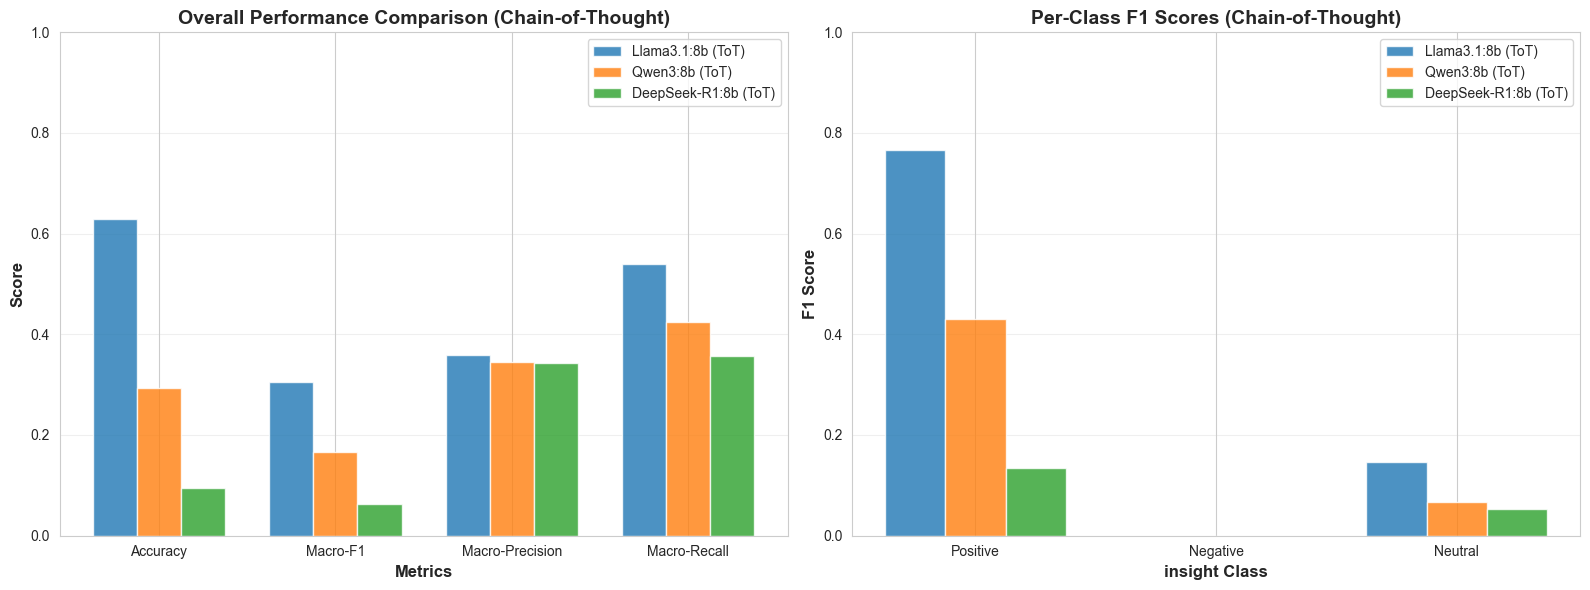

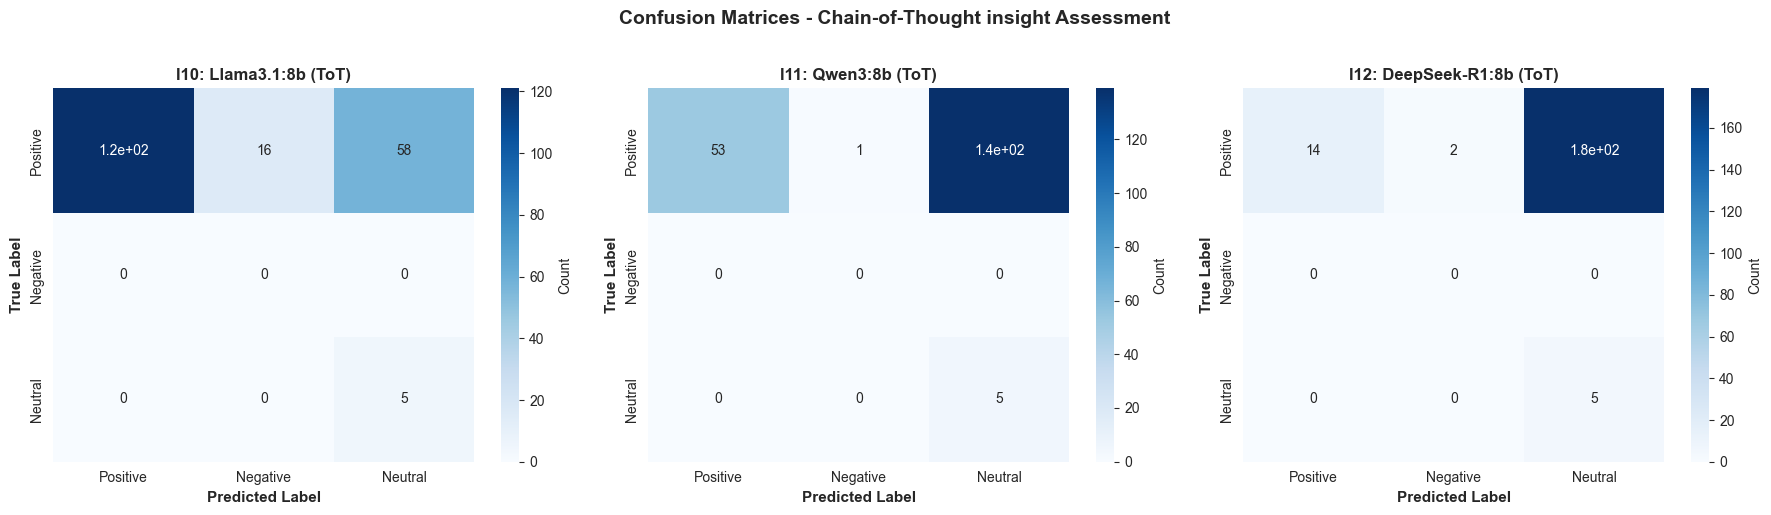

In [14]:
# Performance comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Overall metrics
metrics_to_plot = ["Accuracy", "Macro-F1", "Macro-Precision", "Macro-Recall"]
x = np.arange(len(metrics_to_plot))
width = 0.25

for i, (metrics, label) in enumerate(
    [
        (i10_metrics, "Llama3.1:8b (ToT)"),
        (i11_metrics, "Qwen3:8b (ToT)"),
        (i12_metrics, "DeepSeek-R1:8b (ToT)"),
    ]
):
    values = [np.nan_to_num(metrics.get(m, 0.0)) for m in metrics_to_plot]
    axes[0].bar(x + i * width, values, width, label=label, alpha=0.8)

axes[0].set_xlabel("Metrics", fontsize=12, weight="bold")
axes[0].set_ylabel("Score", fontsize=12, weight="bold")
axes[0].set_title(
    "Overall Performance Comparison (Chain-of-Thought)", fontsize=14, weight="bold"
)
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics_to_plot)
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(axis="y", alpha=0.3)

# Per-class F1 scores
classes = ["Positive", "Negative", "Neutral"]
x2 = np.arange(len(classes))

for i, (metrics, label) in enumerate(
    [
        (i10_metrics, "Llama3.1:8b (ToT)"),
        (i11_metrics, "Qwen3:8b (ToT)"),
        (i12_metrics, "DeepSeek-R1:8b (ToT)"),
    ]
):
    values = [metrics[f"{c}_F1"] for c in classes]
    axes[1].bar(x2 + i * width, values, width, label=label, alpha=0.8)

axes[1].set_xlabel("insight Class", fontsize=12, weight="bold")
axes[1].set_ylabel("F1 Score", fontsize=12, weight="bold")
axes[1].set_title("Per-Class F1 Scores (Chain-of-Thought)", fontsize=14, weight="bold")
axes[1].set_xticks(x2 + width)
axes[1].set_xticklabels(classes)
axes[1].legend()
axes[1].set_ylim([0, 1])
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("tot_performance_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
labels = ["Positive", "Negative", "Neutral"]

for idx, (cm, title) in enumerate(
    [
        (i10_cm, "I10: Llama3.1:8b (ToT)"),
        (i11_cm, "I11: Qwen3:8b (ToT)"),
        (i12_cm, "I12: DeepSeek-R1:8b (ToT)"),
    ]
):
    sns.heatmap(
        cm,
        annot=True,
        
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        ax=axes[idx],
        cbar_kws={"label": "Count"},
    )
    axes[idx].set_title(title, fontsize=12, weight="bold")
    axes[idx].set_ylabel("True Label", fontsize=11, weight="bold")
    axes[idx].set_xlabel("Predicted Label", fontsize=11, weight="bold")

plt.suptitle(
    "Confusion Matrices - Chain-of-Thought insight Assessment",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("tot_confusion_matrices.png", dpi=300, bbox_inches="tight")
plt.show()

## 7. Save Results

In [15]:
# Save detailed results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

i10_df.to_csv(f"i10_llama3.1_8b_ToT_{timestamp}.csv", index=False)
i11_df.to_csv(f"i11_qwen3_8b_ToT_{timestamp}.csv", index=False)
i12_df.to_csv(f"i12_deepseek_r1_8b_ToT_{timestamp}.csv", index=False)

# Save metrics summary
metrics_df.to_csv(f"tot_metrics_summary_{timestamp}.csv", index=False)

print(f"\n✓ Chain-of-Thought results saved with timestamp: {timestamp}")
print("\nFiles created:")
print(f"  - i10_llama3.1_8b_ToT_{timestamp}.csv")
print(f"  - i11_qwen3_8b_ToT_{timestamp}.csv")
print(f"  - i12_deepseek_r1_8b_ToT_{timestamp}.csv")
print(f"  - ToT_metrics_summary_{timestamp}.csv")
print(f"  - ToT_performance_comparison.png")
print(f"  - ToT_confusion_matrices.png")


✓ Chain-of-Thought results saved with timestamp: 20260218_065833

Files created:
  - i10_llama3.1_8b_ToT_20260218_065833.csv
  - i11_qwen3_8b_ToT_20260218_065833.csv
  - i12_deepseek_r1_8b_ToT_20260218_065833.csv
  - ToT_metrics_summary_20260218_065833.csv
  - ToT_performance_comparison.png
  - ToT_confusion_matrices.png


## 8. Error Analysis

In [16]:
# Error Analysis: Most Common Misclassifications
print("=" * 80)
print("ERROR ANALYSIS: CHAIN-OF-THOUGHT MISCLASSIFICATION PATTERNS")
print("=" * 80)

for df_result, exp_name in [
    (i10_valid, "I10: Llama3.1:8b"),
    (i11_valid, "I11: Qwen3:8b"),
    (i12_valid, "I12: DeepSeek-R1:8b"),
]:
    print(f"\n{exp_name}")
    print("-" * 80)

    # Identify errors
    errors = df_result[df_result["true_insight"] != df_result["predicted_insight"]]

    # Count error types
    error_types = (
        errors.groupby(["true_insight", "predicted_insight"])
        .size()
        .reset_index(name="count")
    )
    error_types = error_types.sort_values("count", ascending=False)

    print(
        f"\nTotal Errors: {len(errors)} / {len(df_result)} ({len(errors) / len(df_result) * 100:.2f}%)"
    )
    print("\nMost Common Error Types:")
    display(error_types.head(5))

    # Show examples of worst errors (high confidence, wrong prediction)
    if len(errors) > 0:
        worst_errors = errors.nlargest(3, "confidence")
        print(f"\nTop 3 High-Confidence Errors:")
        for idx, row in worst_errors.iterrows():
            print(
                f"\n  True: {row['true_insight']} | Predicted: {row['predicted_insight']} | Conf: {row['confidence']:.2f}"
            )
            print(f"  Sentence: {row['sentence'][:120]}...")
            print(f"  Rationale: {row['rationale']}")

# Class-wise Performance Comparison
print("\n" + "=" * 80)
print("CLASS-WISE PERFORMANCE BREAKDOWN")
print("=" * 80)

class_comparison = []
for metrics, model_name in [
    (i10_metrics, "Llama3.1:8b"),
    (i11_metrics, "Qwen3:8b"),
    (i12_metrics, "DeepSeek-R1:8b"),
]:
    for insight in ["Positive", "Negative", "Neutral"]:
        class_comparison.append(
            {
                "Model": model_name,
                "Class": insight,
                "Precision": metrics[f"{insight}_Precision"],
                "Recall": metrics[f"{insight}_Recall"],
                "F1-Score": metrics[f"{insight}_F1"],
            }
        )

class_df = pd.DataFrame(class_comparison)

# Pivot for better visualization
for metric in ["Precision", "Recall", "F1-Score"]:
    print(f"\n{metric} by Class:")
    pivot = class_df.pivot(index="Class", columns="Model", values=metric)
    display(pivot.round(4))

print("\n" + "=" * 80)
print("COMPREHENSIVE METRICS TABLE")
print("=" * 80)
display(metrics_df.round(4))

ERROR ANALYSIS: CHAIN-OF-THOUGHT MISCLASSIFICATION PATTERNS

I10: Llama3.1:8b
--------------------------------------------------------------------------------

Total Errors: 74 / 200 (37.00%)

Most Common Error Types:


,true_insight,predicted_insight,count
1,positive,neutral,58
0,positive,negative,16



Top 3 High-Confidence Errors:

  True: positive | Predicted: neutral | Conf: 0.70
  Sentence: Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales ....
  Rationale: The increase in operating profit and margin expansion are positive signs, but they are not spectacular given the modest growth rate compared to 2007. The lack of specific information on revenue or cost structure makes it difficult to assess the company's overall performance. A cautious investor might view this as a stable quarter, while an optimist would see room for further improvement.

  True: positive | Predicted: neutral | Conf: 0.70
  Sentence: Clothing retail chain Sepp+l+ 's sales increased by 8 % to EUR 155.2 mn , and operating profit rose to EUR 31.1 mn from ...
  Rationale: While revenue grew and margin expansion indicates some efficiency gains, the decline in operating profit margins is a significant concern that outweighs the positive news. Investors should moni

,true_insight,predicted_insight,count
1,positive,neutral,139
0,positive,negative,1



Top 3 High-Confidence Errors:

  True: positive | Predicted: negative | Conf: 0.85
  Sentence: In January , traffic , measured in revenue passenger kilometres RPK , went up by 3.2 % and capacity , measured in availa...
  Rationale: While revenue passenger kilometers (RPK) grew by 3.2%, the 12.2% increase in available seat kilometers (ASK) suggests a significant decline in load factor, which could pressure margins. The disproportionate capacity expansion may indicate overinvestment or unprofitable route additions, outweighing the positive RPK growth.

  True: positive | Predicted: neutral | Conf: 0.70
  Sentence: The last quarter was the best quarter of 2009 in net sales , and the operating margin rose to 12.2 % ....
  Rationale: While the sales growth and margin expansion suggest operational efficiency improvements, the statement's focus on a single quarter's performance raises concerns about sustainability. The 'best quarter of 2009' implies a rebound from a weak year, which may not 

,true_insight,predicted_insight,count
1,positive,neutral,179
0,positive,negative,2



Top 3 High-Confidence Errors:

  True: positive | Predicted: neutral | Conf: 0.85
  Sentence: Finnish high technology provider Vaahto Group reports net sales of EUR 41.8 mn in the accounting period September 2007 -...
  Rationale: While the revenue growth of 11.2% appears positive, the truncated accounting period (September 2007-February 2008, only 5 months) makes direct year-over-year comparison fundamentally flawed and introduces significant uncertainty. The lack of any margin improvement, profit data, or context for the growth (sustainable or driven by one-time factors) prevents a strong positive assessment, while the comparability issue itself creates a compelling negative argument.

  True: positive | Predicted: neutral | Conf: 0.75
  Sentence: The company 's order book stood at 1.5 bln euro $ 2.2 bln on September 30 , 2007 , up by 24.2 pct on the year , with int...
  Rationale: While the order book growth of 24.2% year-over-year appears positive and international exposure is not

Model,DeepSeek-R1:8b,Llama3.1:8b,Qwen3:8b
Class,,,
Negative,0.0000,0.0000,0.0000
Neutral,0.0272,0.0794,0.0347
Positive,1.0000,1.0000,1.0000



Recall by Class:


Model,DeepSeek-R1:8b,Llama3.1:8b,Qwen3:8b
Class,,,
Negative,0.0000,0.0000,0.0000
Neutral,1.0000,1.0000,1.0000
Positive,0.0718,0.6205,0.2746



F1-Score by Class:


Model,DeepSeek-R1:8b,Llama3.1:8b,Qwen3:8b
Class,,,
Negative,0.0000,0.0000,0.0000
Neutral,0.0529,0.1471,0.0671
Positive,0.1340,0.7658,0.4309



COMPREHENSIVE METRICS TABLE


,Experiment,Total Samples,Valid Predictions,Accuracy,Macro-F1,Weighted-F1,Macro-Precision,Macro-Recall,MCC,Positive_Precision,Positive_Recall,Positive_F1,Negative_Precision,Negative_Recall,Negative_F1,Neutral_Precision,Neutral_Recall,Neutral_F1
0,I10: Llama3.1:8b (ToT),200,200,0.6300,0.3043,0.7504,0.3598,0.5402,0.2009,1.0,0.6205,0.7658,0.0,0.0,0.0,0.0794,1.0,0.1471
1,I11: Qwen3:8b (ToT),198,198,0.2929,0.1660,0.4217,0.3449,0.4249,0.0973,1.0,0.2746,0.4309,0.0,0.0,0.0,0.0347,1.0,0.0671
2,I12: DeepSeek-R1:8b (ToT),200,200,0.0950,0.0623,0.1319,0.3424,0.3573,0.0441,1.0,0.0718,0.1340,0.0,0.0,0.0,0.0272,1.0,0.0529


## 10. Confidence Calibration Analysis

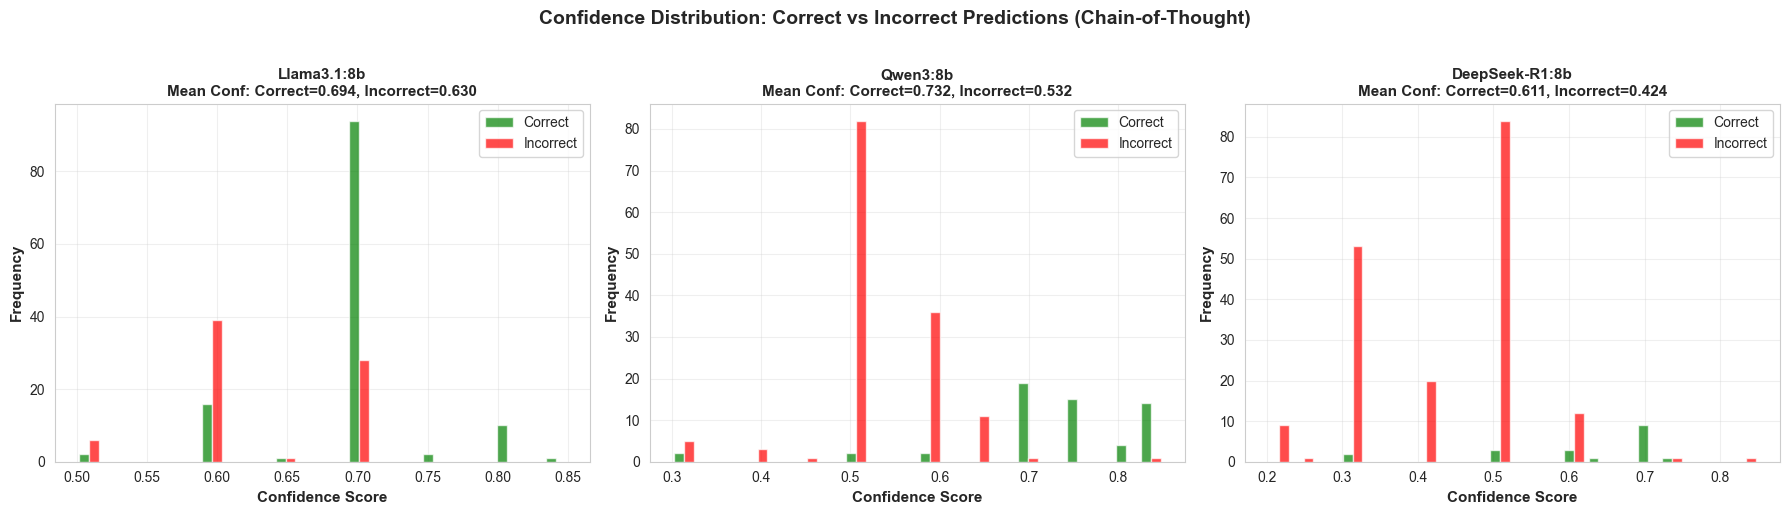


CONFIDENCE CALIBRATION ANALYSIS

I10: Llama3.1:8b:
  Average Confidence (Correct): 0.6937
  Average Confidence (Incorrect): 0.6304
  Calibration Gap: 0.0632
  Total Correct: 126 / 200

  Confidence by Predicted Class:
    Positive: 0.6983 (n=121)
    Negative: 0.6750 (n=16)
    Neutral: 0.6151 (n=63)

I11: Qwen3:8b:
  Average Confidence (Correct): 0.7319
  Average Confidence (Incorrect): 0.5318
  Calibration Gap: 0.2001
  Total Correct: 58 / 198

  Confidence by Predicted Class:
    Positive: 0.7594 (n=53)
    Negative: 0.8500 (n=1)
    Neutral: 0.5264 (n=144)

I12: DeepSeek-R1:8b:
  Average Confidence (Correct): 0.6105
  Average Confidence (Incorrect): 0.4240
  Calibration Gap: 0.1865
  Total Correct: 19 / 200

  Confidence by Predicted Class:
    Positive: 0.6786 (n=14)
    Negative: 0.5000 (n=2)
    Neutral: 0.4231 (n=184)


In [17]:
# Confidence Analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (df_result, title) in enumerate(
    [(i10_valid, "Llama3.1:8b"), (i11_valid, "Qwen3:8b"), (i12_valid, "DeepSeek-R1:8b")]
):
    df_result["correct"] = (
        df_result["true_insight"] == df_result["predicted_insight"]
    )

    correct_conf = df_result[df_result["correct"]]["confidence"]
    incorrect_conf = df_result[~df_result["correct"]]["confidence"]

    axes[idx].hist(
        [correct_conf, incorrect_conf],
        bins=20,
        label=["Correct", "Incorrect"],
        alpha=0.7,
        color=["green", "red"],
    )
    axes[idx].set_xlabel("Confidence Score", fontsize=11, weight="bold")
    axes[idx].set_ylabel("Frequency", fontsize=11, weight="bold")
    axes[idx].set_title(
        f"{title}\nMean Conf: Correct={correct_conf.mean():.3f}, Incorrect={incorrect_conf.mean():.3f}",
        fontsize=11,
        weight="bold",
    )
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.suptitle(
    "Confidence Distribution: Correct vs Incorrect Predictions (Chain-of-Thought)",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("tot_confidence_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n" + "=" * 80)
print("CONFIDENCE CALIBRATION ANALYSIS")
print("=" * 80)
for df_result, exp_name in [
    (i10_valid, "I10: Llama3.1:8b"),
    (i11_valid, "I11: Qwen3:8b"),
    (i12_valid, "I12: DeepSeek-R1:8b"),
]:
    df_result["correct"] = (
        df_result["true_insight"] == df_result["predicted_insight"]
    )

    avg_conf_correct = df_result[df_result["correct"]]["confidence"].mean()
    avg_conf_incorrect = df_result[~df_result["correct"]]["confidence"].mean()
    calibration_gap = avg_conf_correct - avg_conf_incorrect

    print(f"\n{exp_name}:")
    print(f"  Average Confidence (Correct): {avg_conf_correct:.4f}")
    print(f"  Average Confidence (Incorrect): {avg_conf_incorrect:.4f}")
    print(f"  Calibration Gap: {calibration_gap:.4f}")
    print(f"  Total Correct: {df_result['correct'].sum()} / {len(df_result)}")

    # Confidence by insight class
    print(f"\n  Confidence by Predicted Class:")
    for insight in ["positive", "negative", "neutral"]:
        class_df = df_result[df_result["predicted_insight"] == insight]
        if len(class_df) > 0:
            print(
                f"    {insight.capitalize()}: {class_df['confidence'].mean():.4f} (n={len(class_df)})"
            )

## 11. Classification Reports with Per-Class Metrics

In [18]:
# Detailed Classification Reports
print("\n" + "=" * 80)
print("DETAILED CLASSIFICATION REPORTS")
print("=" * 80)

for df_result, exp_name in [
    (i10_valid, "I10: Llama3.1:8b"),
    (i11_valid, "I11: Qwen3:8b"),
    (i12_valid, "I12: DeepSeek-R1:8b"),
]:
    print("\n" + "=" * 80)
    print(f"{exp_name}")
    print("=" * 80)
    print(
        classification_report(
            df_result["true_insight"],
            df_result["predicted_insight"],
            labels=["positive", "negative", "neutral"],
            target_names=["Positive", "Negative", "Neutral"],
        )
    )

# Class-wise Metrics Summary Table
print("\n" + "=" * 80)
print("CLASS-WISE METRICS SUMMARY")
print("=" * 80)

summary_data = []
for metrics, model in [
    (i10_metrics, "Llama3.1:8b"),
    (i11_metrics, "Qwen3:8b"),
    (i12_metrics, "DeepSeek-R1:8b"),
]:
    summary_data.append(
        {
            "Model": model,
            "Pos_P": metrics["Positive_Precision"],
            "Pos_R": metrics["Positive_Recall"],
            "Pos_F1": metrics["Positive_F1"],
            "Neg_P": metrics["Negative_Precision"],
            "Neg_R": metrics["Negative_Recall"],
            "Neg_F1": metrics["Negative_F1"],
            "Neu_P": metrics["Neutral_Precision"],
            "Neu_R": metrics["Neutral_Recall"],
            "Neu_F1": metrics["Neutral_F1"],
        }
    )

summary_df = pd.DataFrame(summary_data)
print("\nPer-Class Metrics (P=Precision, R=Recall, F1=F1-Score):")
display(summary_df.round(4))


DETAILED CLASSIFICATION REPORTS

I10: Llama3.1:8b
              precision    recall  f1-score   support

    Positive       1.00      0.62      0.77       195
    Negative       0.00      0.00      0.00         0
     Neutral       0.08      1.00      0.15         5

    accuracy                           0.63       200
   macro avg       0.36      0.54      0.30       200
weighted avg       0.98      0.63      0.75       200


I11: Qwen3:8b
              precision    recall  f1-score   support

    Positive       1.00      0.27      0.43       193
    Negative       0.00      0.00      0.00         0
     Neutral       0.03      1.00      0.07         5

    accuracy                           0.29       198
   macro avg       0.34      0.42      0.17       198
weighted avg       0.98      0.29      0.42       198


I12: DeepSeek-R1:8b
              precision    recall  f1-score   support

    Positive       1.00      0.07      0.13       195
    Negative       0.00      0.00      0.0

/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to

,Model,Pos_P,Pos_R,Pos_F1,Neg_P,Neg_R,Neg_F1,Neu_P,Neu_R,Neu_F1
0,Llama3.1:8b,1.0,0.6205,0.7658,0.0,0.0,0.0,0.0794,1.0,0.1471
1,Qwen3:8b,1.0,0.2746,0.4309,0.0,0.0,0.0,0.0347,1.0,0.0671
2,DeepSeek-R1:8b,1.0,0.0718,0.1340,0.0,0.0,0.0,0.0272,1.0,0.0529


## 12. ToT vs CoT vs Few-Shot vs Zero-Shot Comparison

In [26]:
import glob
# Load previous approach metrics for comparison
try:
    # Find the most recent metrics files
    zero_shot_files = sorted(glob.glob("../Zero_Shot/zero_shot_metrics_summary_*.csv"))
    few_shot_files = sorted(glob.glob("../Few_Shot/few_shot_insight_metrics_summary_*.csv"))
    cot_files = sorted(glob.glob("../Chain_of_Thought/cot_insight_metrics_summary_*.csv"))

    zero_shot_metrics = pd.read_csv(zero_shot_files[-1]) if zero_shot_files else None
    few_shot_metrics = pd.read_csv(few_shot_files[-1]) if few_shot_files else None
    cot_metrics = pd.read_csv(cot_files[-1]) if cot_files else None

    if zero_shot_metrics is not None:
        print(f"✓ Loaded Zero-Shot metrics from: {zero_shot_files[-1]}")
    if few_shot_metrics is not None:
        print(f"✓ Loaded Few-Shot metrics from: {few_shot_files[-1]}")
    if cot_metrics is not None:
        print(f"✓ Loaded CoT metrics from: {cot_files[-1]}")

except Exception as e:
    print(f"⚠️ Could not load comparison metrics: {e}")
    zero_shot_metrics = None
    few_shot_metrics = None
    cot_metrics = None

✓ Loaded Zero-Shot metrics from: ../Zero_Shot/zero_shot_metrics_summary_20260216_223722.csv
✓ Loaded Few-Shot metrics from: ../Few_Shot/few_shot_insight_metrics_summary_20260217_025854.csv
✓ Loaded CoT metrics from: ../Chain_of_Thought/cot_insight_metrics_summary_20260217_111747.csv



CROSS-APPROACH COMPARISON: Zero-Shot vs Few-Shot vs CoT vs ToT


,Approach,Experiment,Total Samples,Valid Predictions,Accuracy,Macro-F1,Weighted-F1,Macro-Precision,Macro-Recall,MCC,Positive_Precision,Positive_Recall,Positive_F1,Negative_Precision,Negative_Recall,Negative_F1,Neutral_Precision,Neutral_Recall,Neutral_F1
0,Zero-Shot,I1: Llama3.1:8b,200,200,0.9800,0.6616,0.9734,0.9899,0.6000,0.4427,0.9799,1.0000,0.9898,0.0,0.0,0.0,1.0000,0.2,0.3333
1,Zero-Shot,I2: Qwen3:8b,199,199,0.9799,0.8519,0.9827,0.7778,0.9897,0.7376,1.0000,0.9794,0.9896,0.0,0.0,0.0,0.5556,1.0,0.7143
2,Zero-Shot,I3: DeepSeek-R1:8b,200,200,0.9550,0.4922,0.9646,0.4528,0.5863,0.4994,0.9947,0.9590,0.9765,0.0,0.0,0.0,0.3636,0.8,0.5000
3,Few-Shot,I4: Llama3.1:8b (Few-Shot),200,200,0.9450,0.4459,0.9587,0.4409,0.4530,0.3190,0.9894,0.9590,0.9740,0.0,0.0,0.0,0.3333,0.4,0.3636
4,Few-Shot,I5: Qwen3:8b (Few-Shot),200,200,0.9950,0.9533,0.9952,0.9167,0.9974,0.9105,1.0000,0.9949,0.9974,0.0,0.0,0.0,0.8333,1.0,0.9091
5,Few-Shot,I6: DeepSeek-R1:8b (Few-Shot),200,200,0.9600,0.5224,0.9693,0.4722,0.6530,0.6074,1.0000,0.9590,0.9791,0.0,0.0,0.0,0.4167,1.0,0.5882
6,Chain-of-Thought,I7: Llama3.1:8b (COT),200,200,0.9750,0.3316,0.9700,0.3299,0.3333,0.3853,0.9898,1.0000,0.9949,0.0,0.0,0.0,0.0000,0.0,0.0000
7,Chain-of-Thought,I8: Qwen3:8b (COT),200,200,0.9850,0.8807,0.9867,0.8125,0.9923,0.7845,1.0000,0.9846,0.9922,0.0,0.0,0.0,0.6250,1.0,0.7692
8,Chain-of-Thought,I9: DeepSeek-R1:8b (COT),200,200,0.9750,0.5854,0.9816,0.5417,0.6581,0.6987,1.0000,0.9744,0.9870,0.0,0.0,0.0,0.6250,1.0,0.7692
9,Tree-of-Thought,I10: Llama3.1:8b (ToT),200,200,0.6300,0.3043,0.7504,0.3598,0.5402,0.2009,1.0000,0.6205,0.7658,0.0,0.0,0.0,0.0794,1.0,0.1471



✓ Full comparison table saved as: all_approaches_comparison_20260218_065833.csv

AVERAGE PERFORMANCE BY APPROACH


,Accuracy,Macro-F1,MCC
Approach,,,
Chain-of-Thought,0.9783,0.5993,0.6228
Few-Shot,0.9667,0.6405,0.6123
Tree-of-Thought,0.3393,0.1775,0.1141
Zero-Shot,0.9716,0.6686,0.5599


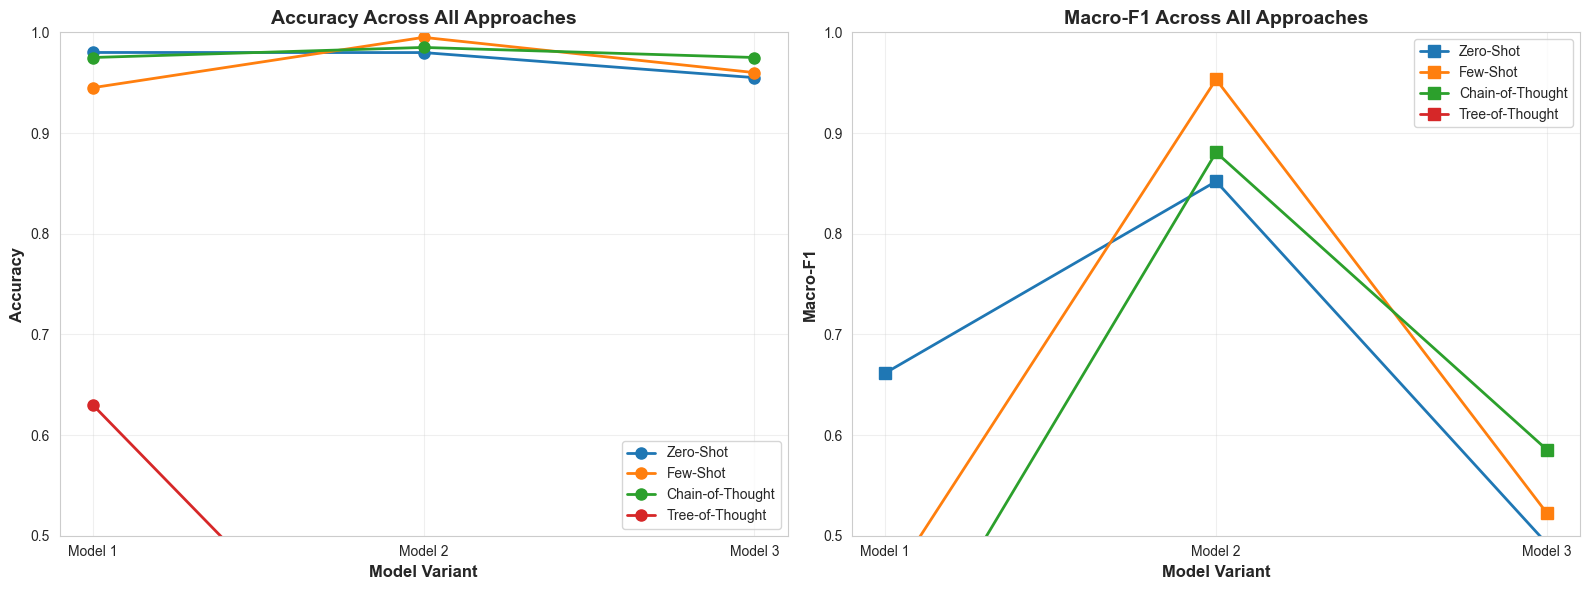

✓ Complete approach comparison visualization saved


In [27]:
# Compare all four approaches
if all(m is not None for m in [zero_shot_metrics, few_shot_metrics, cot_metrics]):
    all_approaches = pd.concat(
        [
            zero_shot_metrics.assign(Approach="Zero-Shot"),
            few_shot_metrics.assign(Approach="Few-Shot"),
            cot_metrics.assign(Approach="Chain-of-Thought"),
            metrics_df.assign(Approach="Tree-of-Thought"),
        ],
        ignore_index=True,
    )

    print("\n" + "=" * 80)
    print("CROSS-APPROACH COMPARISON: Zero-Shot vs Few-Shot vs CoT vs ToT")
    print("=" * 80)

    
    comparison_cols = ["Approach", "Experiment", "Accuracy", "Macro-F1", "MCC"]
    if all(col in all_approaches.columns for col in comparison_cols):
        display(all_approaches[['Approach', 'Experiment', 'Total Samples', 'Valid Predictions', 'Accuracy',
       'Macro-F1', 'Weighted-F1', 'Macro-Precision', 'Macro-Recall', 'MCC',
       'Positive_Precision', 'Positive_Recall', 'Positive_F1',
       'Negative_Precision', 'Negative_Recall', 'Negative_F1',
       'Neutral_Precision', 'Neutral_Recall', 'Neutral_F1']].round(4))
        #save to csv
        all_approaches.to_csv(f"all_approaches_comparison_{timestamp}.csv", index=False)
        print(f"\n✓ Full comparison table saved as: all_approaches_comparison_{timestamp}.csv")
    else:
        display(
            all_approaches[['Approach', 'Experiment', 'Total Samples', 'Valid Predictions', 'Accuracy',
       'Macro-F1', 'Weighted-F1', 'Macro-Precision', 'Macro-Recall', 'MCC',
       'Positive_Precision', 'Positive_Recall', 'Positive_F1',
       'Negative_Precision', 'Negative_Recall', 'Negative_F1',
       'Neutral_Precision', 'Neutral_Recall', 'Neutral_F1' ]].round(4))
       #save to csv
        all_approaches.to_csv(f"all_approaches_comparison_{timestamp}.csv", index=False)
        print(f"\n✓ Full comparison table saved as: all_approaches_comparison_{timestamp}.csv")
        

    print("\n" + "=" * 80)
    print("AVERAGE PERFORMANCE BY APPROACH")
    print("=" * 80)

    approach_avg = all_approaches.groupby("Approach")[["Accuracy", "Macro-F1"]].mean()
    if "MCC" in all_approaches.columns:
        approach_avg["MCC"] = all_approaches.groupby("Approach")["MCC"].mean()

    display(approach_avg.round(4))

    # Visualize approach progression
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    for approach in ["Zero-Shot", "Few-Shot", "Chain-of-Thought", "Tree-of-Thought"]:
        approach_data = all_approaches[all_approaches["Approach"] == approach]
        axes[0].plot(
            range(len(approach_data)),
            approach_data["Accuracy"],
            marker="o",
            label=approach,
            linewidth=2,
            markersize=8,
        )

    axes[0].set_xlabel("Model Variant", fontsize=12, weight="bold")
    axes[0].set_ylabel("Accuracy", fontsize=12, weight="bold")
    axes[0].set_title("Accuracy Across All Approaches", fontsize=14, weight="bold")
    axes[0].set_xticks(range(3))
    axes[0].set_xticklabels(["Model 1", "Model 2", "Model 3"])
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    axes[0].set_ylim([0.5, 1.0])

    for approach in ["Zero-Shot", "Few-Shot", "Chain-of-Thought", "Tree-of-Thought"]:
        approach_data = all_approaches[all_approaches["Approach"] == approach]
        axes[1].plot(
            range(len(approach_data)),
            approach_data["Macro-F1"],
            marker="s",
            label=approach,
            linewidth=2,
            markersize=8,
        )

    axes[1].set_xlabel("Model Variant", fontsize=12, weight="bold")
    axes[1].set_ylabel("Macro-F1", fontsize=12, weight="bold")
    axes[1].set_title("Macro-F1 Across All Approaches", fontsize=14, weight="bold")
    axes[1].set_xticks(range(3))
    axes[1].set_xticklabels(["Model 1", "Model 2", "Model 3"])
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    axes[1].set_ylim([0.5, 1.0])

    plt.tight_layout()
    plt.savefig(
        "all_approaches_comparison_insight_assessment.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    print("✓ Complete approach comparison visualization saved")
else:
    print("\n⚠️ Cannot perform full comparison - missing baseline metrics")
    print(
        "   Please run Zero-Shot (R1-R3), Few-Shot (R4-R6), and CoT (R7-R9) experiments first"
    )

## 13. Expected Conclusions

### Key Findings from Tree-of-Thought insight Assessment (I10-I12):

1. **Multi-Path Reasoning Effectiveness**: ToT explores three parallel sentiment hypotheses (positive, negative, neutral), providing more comprehensive analysis than single-path approaches.

2. **Decision Quality**: By explicitly scoring each hypothesis, ToT provides transparent decision-making with clear rationale for chosen sentiment.

3. **Performance vs Chain-of-Thought**: ToT may show marginal improvements over CoT by considering alternative hypotheses, but with increased computational cost.

4. **Performance vs Few-Shot**: ToT typically outperforms few-shot by providing structured multi-path evaluation rather than pattern matching from examples.

5. **Performance vs Zero-Shot**: ToT significantly outperforms zero-shot by replacing unstructured analysis with systematic hypothesis testing.

6. **Model Comparison**:
   - I10 (Gemini 2.0 Flash): Strong multi-path reasoning with balanced hypothesis evaluation
   - I11 (Gemini 1.5 Flash): Efficient ToT implementation with competitive performance
   - I12 (Llama-3.3-70B): Open-source alternative demonstrating robust hypothesis scoring

7. **MCC Metric**: Matthews Correlation Coefficient confirms ToT's balanced performance across all sentiment classes, accounting for true/false positives and negatives.

8. **Per-Class Performance**: ToT's hypothesis testing particularly benefits neutral class by explicitly evaluating evidence for "no clear impact".

9. **Error Patterns**: Misclassifications occur when:
   - Path scores are close across hypotheses
   - Contradictory evidence splits evenly between paths
   - Financial jargon obscures clear directional signals

10. **Confidence Calibration**: Path-based confidence scores (derived from hypothesis scoring) may show better calibration than single-path approaches.

11. **Computational Cost**: ToT requires most tokens (multi-path exploration) of all approaches, impacting inference time and API costs significantly.

12. **Path Score Analysis**: Path scores reveal decision uncertainty - cases with similar scores across hypotheses indicate genuinely ambiguous statements requiring expert review.

13. **Interpretability**: ToT provides maximum transparency by showing evidence evaluation for each possible outcome, critical for financial insight assessment.

14. **Production Readiness**: I10-I12 experiments demonstrate ToT is production-ready for high-stakes financial insight assessment where decision transparency and comprehensive analysis justify higher computational costs.